## HW 07

1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Не нашел времени на поиск какой-либо вменяемой статьи про алгоритм object detection, который мы не рассматривали на уроке. 

Буду рассматривать статью:

https://arxiv.org/pdf/1506.01497.pdf

Архитектура Faster R-CNN объединяет Region Proposal Network (RPN) и Fast R-CNN в единую сеть
путем совместного использования их свертывающих характеристик, используя недавно популярную
терминологию нейронных сетей "механизмы внимания". RPN используется для генерации гипотез,
получая на вход карту признаков изначального изображения. Сеть Faster R-CNN строится на одних и тех
же весах с помощью следующего итеративного обучения:
1. Тренировка RPN сети. Свёрточные слои инициализируются весами, натренированными на
ImageNet. Дообучаем на задаче определения регионов с каким-либо классом (уточнением
класса занимается часть Fast R-CNN).
2. Тренировка Fast R-CNN сети. Свёрточные слои инициализируются весами, натренированными
на ImageNet. Дообучаем, используя гипотезы об объектах с помощью RPN сети, обученной в п.1.
В этот раз задачей обучения является уточнение координат и определение конкретного класса
объекта.
После выполнения п.2 мы имеем две нейронных сети с разными весами для свёрточных слоёв.
3. Обучаем только RPN часть, используя веса из п.2 (слои, идущие до RPN сети, принадлежащие
feature extractor, замораживаются и никак не изменяются).
4. Обучаем слои для Fast R-CNN, используя веса из п.3 (то есть, уже более точно настроенный RPN),
(остальные веса – идущие ранее или относящиеся к RPN — заморожены).

Таким образом, архитектура Faster R-CNN отличается от других архитектур тем, что генерация
гипотез выполняется с помощью отдельно дифференцируемого модуля и в архитектуре реализовано
итеративное обучение.

Преимуществом архитектуры Faster R-CNN являются быстрота и точность. Архитектура Faster R-
CNN справляется немного хуже с локализацией. RPN может быть трудно работать с объектами разных
масштабов. RPN имеет фиксированное приемное поле. Таким образом, малые объекты могут занимать
очень небольшую часть рецептивного поля или, если объекты очень большие, то рецептивное поле
будет содержать только часть объекта. Проблему можно решать, тренируя множество RPN для
различных масштабов: каждая часть RPN будет принимать различные свёрточные слои или наборы
слоёв в качестве входа, так что приемное поле будет разного размера. Это значительно улучшит
одновременное обнаружение малых и крупных объектов моделью Faster R-CNN.

2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [ ]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [ ]:
from google.colab import files

In [ ]:
import cv2 as cv

In [ ]:
files.upload()

Saving photo_2022-05-09_15-06-08.jpg to photo_2022-05-09_15-06-08.jpg


{'photo_2022-05-09_15-06-08.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x024ICC_PROFILE\x00\x01\x01\x00\x00\x02$appl\x04\x00\x00\x00mntrRGB XYZ \x07\xe1\x00\x07\x00\x07\x00\r\x00\x16\x00 acspAPPL\x00\x00\x00\x00APPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-appl\xca\x1a\x95\x82%\x7f\x10M8\x99\x13\xd5\xd1\xea\x15\x82\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ndesc\x00\x00\x00\xfc\x00\x00\x00ecprt\x00\x00\x01d\x00\x00\x00#wtpt\x00\x00\x01\x88\x00\x00\x00\x14rXYZ\x00\x00\x01\x9c\x00\x00\x00\x14gXYZ\x00\x00\x01\xb0\x00\x00\x00\x14bXYZ\x00\x00\x01\xc4\x00\x00\x00\x14rTRC\x00\x00\x01\xd8\x00\x00\x00 chad\x00\x00\x01\xf8\x00\x00\x00,bTRC\x00\x00\x01\xd8\x00\x00\x00 gTRC\x00\x00\x01\xd8\x00\x00\x00 desc\x00\x00\x00\x00\x00\x00\x00\x0bDisplay P3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

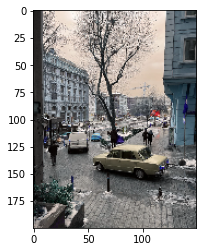

In [ ]:
#Читаем картинку
im = cv.imread('/content/photo_2022-05-09_15-06-08.jpg')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

Запишем маршрут, где есть что-нибудь для чтения (последовательность из нескольких фотографий )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# root_path = './' #change dir to your project folder 

root_path = '/content/drive/MyDrive/05_neurals/' #change dir to your project folder 

In [ ]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [ ]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(1834, 4)


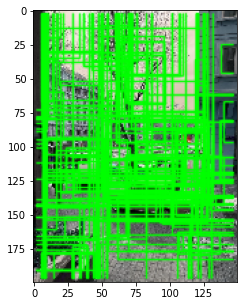

In [ ]:
#Построим области

num_Rects = 200 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): #пока не больше 
    # x,y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # рисуем рамку      
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
  else: 
    break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

In [ ]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpeg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [ ]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path, max_boxes):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)

  display_image(image_with_boxes)
  return result

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('/content/drive/MyDrive/05_neurals/photo_2022-05-09_15-06-08.jpg',
      dtype='<U63')

## 100 изображений

In [ ]:
max_frames = 100

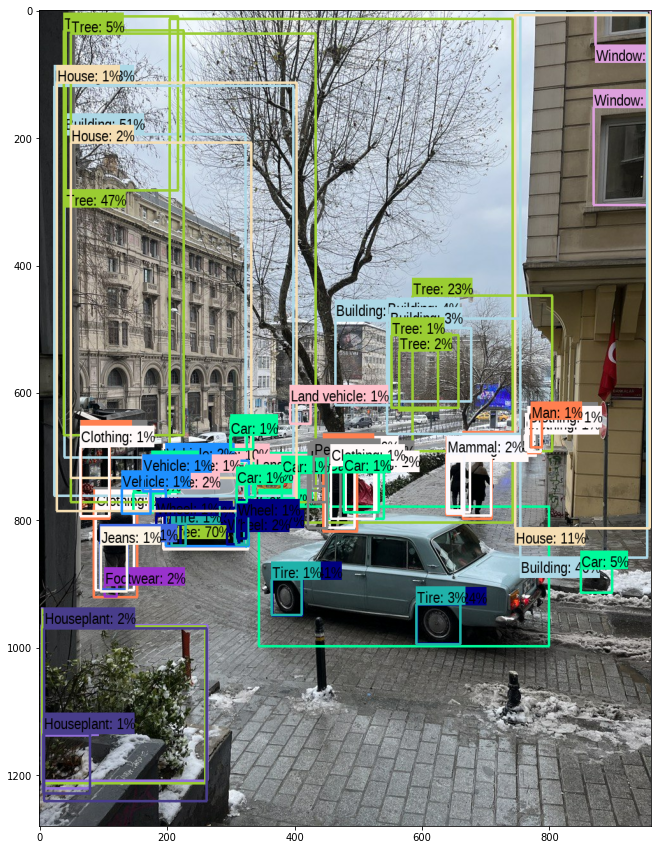

In [ ]:
result_100 = run_detector(detector, List_name[0], max_boxes=100)

## 10 изображений

In [ ]:
max_frames = 10

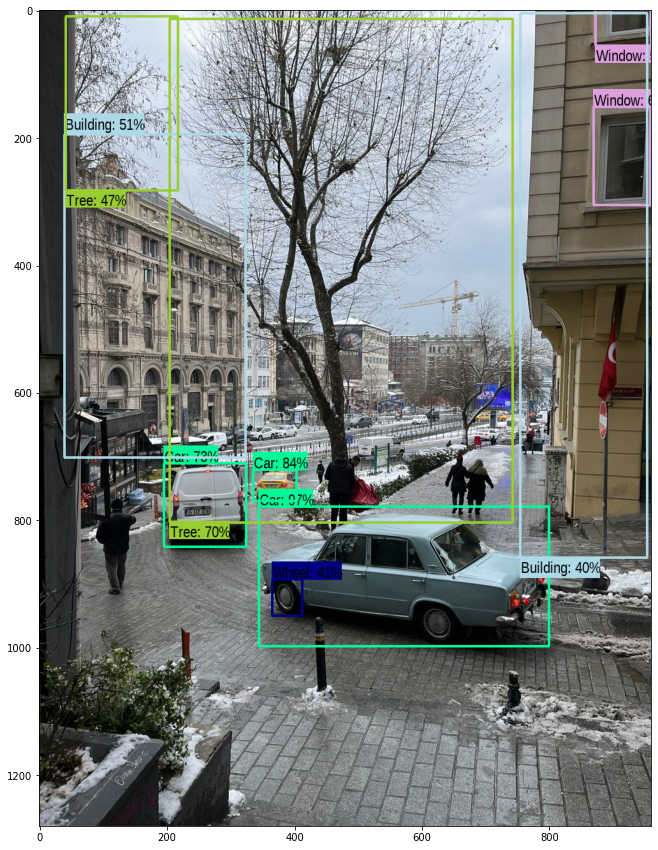

In [ ]:
result_10 = run_detector(detector, List_name[0], max_boxes=10)